In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

# Read in data:
# Cloud_Sections
cloud_sections = pd.read_csv('Cleaned/CLOUD_SECTIONS_Cleaned.csv', delimiter = ',', encoding = 'latin1')

# Designed_Pipe_Center
designed_centers = pd.read_csv('Cleaned/DESIGNED_Pipe_Centers_Cleaned.csv', delimiter = ',', encoding = 'latin1')

# Planes_Local_Global_Cleaned
p_info = pd.read_csv('Cleaned/Planes_Local_Global_Cleaned.csv', delimiter = ',', encoding = 'latin1')

In [2]:
# A List of sections, where each section is a list of tuples, and each tuple is the XY coordinates of a point on the point cloud
TuplePairsBySection = [] 

# A list of the Designed Center points and radius, each object in the list is a panda dataframe where there are as many rows as pipes
CenterList = [] 

# For n in the number of distinct sections
for n in range(cloud_sections.Section.nunique()): 
    
    # Grabs all dataframe rows in each distinct section
    grab = cloud_sections[cloud_sections['Section'] == 'Section-{' + str(n) + '}'] 
    
    # Adds the individual X and Y points in each point cloud pair for the nth section
    TuplePairsBySection.append(list(zip(grab.X, grab.Y))) 
    
    # Adds the dataframe rows in each distinct section
    CenterList.append(designed_centers[designed_centers['Section'] == 'Section-{' + str(n) + '}']) 

In [3]:
# Arbitrary radius multiplier
N = 1.4

# A List of points in the point cloud, by section and pipe, that pass the first noise test
PassesFirstNoiseTestBySection = [] 

# A List of points in the point cloud, by section, that fail the first noise test
FailsFirstNoiseTestBySection = [] 

count = 0 
for section in TuplePairsBySection:
    D, E, F = [], [], []
    
    # Intialize the radius for both pipes
    r1, r2 = CenterList[count].iloc[0,4], CenterList[count].iloc[1,4] 
    
    # Intialize the center XY coordinate tuple for both pipes
    c1, c2 = tuple(CenterList[count].iloc[0,1:3]), tuple(CenterList[count].iloc[1,1:3]) 
    
    for point in section: 
        
        # Test first pipe
        if math.dist(c1, point) < (r1 * N): 
            D.append(point)
            
        # Test second pipe
        elif math.dist(c2, point) < (r2 * N): 
            E.append(point)
        else:
            F.append(point)
            
    PassesFirstNoiseTestBySection.append(D)
    PassesFirstNoiseTestBySection.append(E)
    FailsFirstNoiseTestBySection.append(F)
    count += 1

In [4]:
# Arbitrary IQR multiplier
M = 1.3

def findOutVals(rlist):
    P, F = {}, {}
    P_index = []
    sortedList = sorted(rlist)
    L = len(rlist)
    Q1 = np.median(sortedList[:(L//2 + 2)]) 
    Q3 = np.median(sortedList[(L//2 + 1):])
    IQR = Q3 - Q1
    L_out = Q1 - IQR*M
    R_out = Q3 + IQR*M
    count = 0
    for n in rlist:
        if (n > L_out) and (n < R_out):
            P[count] = n
        count += 1
    for a in P:
        P_index.append(a)
    return P_index

In [5]:
# A List of points in the point cloud, by section and pipe, that pass the first noise test
PassesSecondNoiseTestBySection = [] 

# A List of points in the point cloud, by section, that fail the first noise test
FailsSeconNoiseTestBySection = [] 

count = 0 
for circle in PassesFirstNoiseTestBySection:
    passPoints, failPoints = [], []
    if len(circle) == 0:
        count += 1
    else:
        ResList = []
        if count %2 == 0:
            r = CenterList[count // 2].iloc[0,4]
            c = tuple(CenterList[count // 2].iloc[0,1:3])
            for p in circle:
                ResList.append((math.dist(p, c) - r))
            Pass_index = findOutVals(ResList)
            for n in range(len(circle)):
                if n in Pass_index:
                    passPoints.append(circle[n])
                else:
                    failPoints.append(circle[n])                 
        else:
            r = CenterList[count // 2].iloc[1,4]
            c = tuple(CenterList[count // 2].iloc[1,1:3])
            for p in circle:
                ResList.append((math.dist(p, c) - r))
            findOutVals(ResList)
            Pass_index = findOutVals(ResList)
            for n in range(len(circle)):
                if n in Pass_index:
                    passPoints.append(circle[n])
                else:
                    failPoints.append(circle[n])
            count += 1       
    PassesSecondNoiseTestBySection.append(passPoints)
    FailsSeconNoiseTestBySection.append(failPoints)

FACECOLOR = '#fffefe'
FIGSIZE = (36,36)
TICK_LABELSIZE = 54
TICK_LENGTH = 24
TICK_WIDTH = 4
TITLE_FONTSIZE = 58
MARKER_SIZE = 544

for NUM in range(1):
    
    # Double cleaned sections---------------------------------------------------
    
    double_clean_fig = plt.figure(figsize = FIGSIZE, facecolor = FACECOLOR)
    double_clean_section = double_clean_fig.add_subplot(1,1,1)
    double_clean_section.set_title('Cleaned Twice Section ' + str(NUM))
    double_clean_section.set_facecolor(FACECOLOR)
    double_clean_section.scatter(*zip(*TuplePairsBySection[NUM]), s = MARKER_SIZE)
    double_clean_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    double_clean_section.annotate(str(len(TuplePairsBySection[NUM])), (40, 10))
    double_clean_section.tick_params(labelsize = TICK_LABELSIZE, length = TICK_LENGTH, width = TICK_WIDTH)
    
    # Section 1 circle 3 workaround
    
    if len(PassesSecondNoiseTestBySection[2 * NUM]) > 0: 
        double_clean_section.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM]), color = 'orange') #Circle saved as D
    else: 
        print('Circle ' + str(2 * NUM) + ' from Section ' + str(NUM) + ' has no values.')

    double_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM])) + '/' + str(len(PassesFirstNoiseTestBySection[2 * NUM])),
                 (CenterList[NUM].iloc[0,1] + 10, CenterList[NUM].iloc[0,2]))
    
    # Section 1 circle 3 workaround
    
    if len(PassesSecondNoiseTestBySection[2 * NUM + 1]) > 0: 
        double_clean_section.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM + 1]), color = 'yellow')  #Circle saved as E
    else: 
        print('Circle ' + str(2 * NUM + 1) + ' from Section ' + str(NUM) + ' has no values.')

    double_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM + 1])) + '/' + str(len(PassesFirstNoiseTestBySection[2 * NUM + 1])),
                  (CenterList[NUM].iloc[1,1] + 10, CenterList[NUM].iloc[1,2] + 10))
    double_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM]) + len(PassesSecondNoiseTestBySection[2 * NUM + 1])), (40, 10))
    double_clean_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    
    # save final figure
    # Uncomment following line when ready to save images
    
    #double_clean_fig.savefig('Results/Cleaned_Twice_Sections/cleaned_twice_section_' + str(NUM) + '.png', facecolor = double_clean_fig.get_facecolor())
    
    # Single cleaned sections---------------------------------------------------
    
    single_clean_fig = plt.figure(figsize = FIGSIZE, facecolor = FACECOLOR)
    single_clean_section = single_clean_fig.add_subplot(1,1,1)
    single_clean_section.set_title('Cleaned Once Section ' + str(NUM))
    single_clean_section.set_facecolor(FACECOLOR)
    single_clean_section.scatter(*zip(*TuplePairsBySection[NUM]), s = MARKER_SIZE)
    single_clean_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    single_clean_section.annotate(str(len(TuplePairsBySection[NUM])), (40, 10))
    single_clean_section.tick_params(labelsize = TICK_LABELSIZE, length = TICK_LENGTH, width = TICK_WIDTH)
    
    # Section 1 circle 3 workaround
    
    if len(PassesSecondNoiseTestBySection[2 * NUM]) > 0: 
        single_clean_section.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM]), color = 'orange', s = MARKER_SIZE) #Circle saved as D
    else: 
        print('Circle ' + str(2 * NUM) + ' from Section ' + str(NUM) + ' has no values.')

    single_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM])) + '/' + str(len(PassesFirstNoiseTestBySection[2 * NUM])),
                 (CenterList[NUM].iloc[0,1] + 10, CenterList[NUM].iloc[0,2]))
    
    # Section 1 circle 3 workaround
    
    if len(PassesSecondNoiseTestBySection[2 * NUM + 1]) > 0: 
        single_clean_section.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM + 1]), color = 'yellow', s = MARKER_SIZE)  #Circle saved as E
    else: 
        print('Circle ' + str(2 * NUM + 1) + ' from Section ' + str(NUM) + ' has no values.')

    single_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM + 1])) + '/' + str(len(PassesFirstNoiseTestBySection[2 * NUM + 1])),
                  (CenterList[NUM].iloc[1,1] + 10, CenterList[NUM].iloc[1,2] + 10))

    single_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM]) + len(PassesSecondNoiseTestBySection[2 * NUM + 1])), (40, 10))
    single_clean_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    
    # save final figure
    # Uncomment following line when ready to save images
    
    #single_clean_fig.savefig('Results/Cleaned_Once_Sections/cleaned_once_section_' + str(NUM) + '.png', facecolor = single_clean_fig.get_facecolor())
    
    # Original Section----------------------------------------------------------
    
    original_fig = plt.figure(figsize = FIGSIZE, facecolor = FACECOLOR)
    original_section = original_fig.add_subplot(1,1,1)
    original_section.set_title('Original Section ' + str(NUM), fontsize = TITLE_FONTSIZE)
    original_section.set_facecolor(FACECOLOR)
    original_section.scatter(*zip(*TuplePairsBySection[NUM]), s = MARKER_SIZE)
    original_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    original_section.annotate(str(len(TuplePairsBySection[NUM])), (40, 10))
    original_section.tick_params(labelsize = TICK_LABELSIZE, length = TICK_LENGTH, width = TICK_WIDTH)
    # save final figure
    # Uncomment following line when ready to save images
    
    #original_fig.savefig('Results/Original_Sections/original_section_' + str(NUM) + '.png', facecolor = original_fig.get_facecolor())
    
    # Incase these lines are needed 
    #plt.xlim(0, max(x[0] for x in TuplePairsBySection[NUM]) * 1.25)
    #plt.ylim(0, max(y[1] for y in TuplePairsBySection[NUM]) * 1.25)

In [10]:
def printInfo(radius, Xcp, Ycp, secNum, pipeCount):
    #round values
    roundList = [radius, Xcp, Ycp]
    roundList = [round(i, 6) for i in roundList]
    radius = roundList[0]
    Xcp = roundList[1]
    Ycp = roundList[2]
    FCP = (Xcp, Ycp)
    givenR = CenterList[secNum].iloc[pipeCount,4]
    givenC_tuple = tuple(CenterList[secNum].iloc[pipeCount,1:3])
    print("The fitted center point is: (" + str(Xcp) + "," + str(Ycp) + ")")
    print("The as-designed center point is: (" + str(givenC_tuple[0]) + "," + str(givenC_tuple[1]) + ")")
    print("The distance between them is: " + str(round(math.dist(givenC_tuple, FCP), 7)))
    print("The fitted radius is: " + str(radius) + " and the actual radius is: " + str(givenR))
    print("The difference between them is: " + str(round(abs(givenR - radius), 7)))

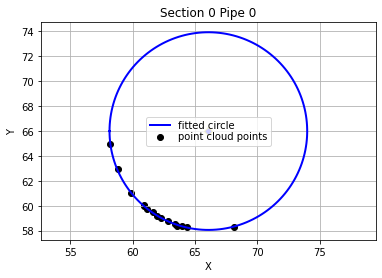

The fitted center point is: (66.074929,65.991929)
The as-designed center point is: (65.408948,63.690596)
The distance between them is: 2.3957596
The fitted radius is: 7.936432 and the actual radius is: 8.0
The difference between them is: 0.063568


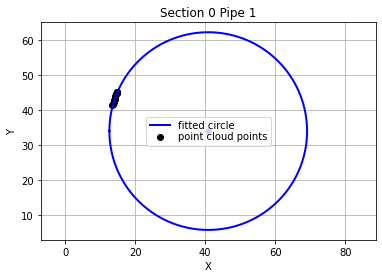

The fitted center point is: (40.871406,33.980269)
The as-designed center point is: (10.082133,41.693907)
The distance between them is: 31.7408182
The fitted radius is: 28.244157 and the actual radius is: 4.375
The difference between them is: 23.869157


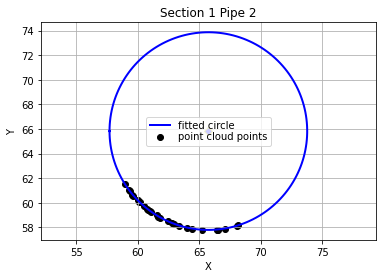

The fitted center point is: (65.747,65.832838)
The as-designed center point is: (65.408948,63.690228)
The distance between them is: 2.1691143
The fitted radius is: 8.036985 and the actual radius is: 8.0
The difference between them is: 0.036985


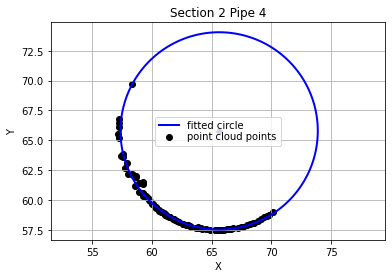

The fitted center point is: (65.623687,65.791554)
The as-designed center point is: (65.408948,63.688344)
The distance between them is: 2.1141441
The fitted radius is: 8.261632 and the actual radius is: 8.0
The difference between them is: 0.261632


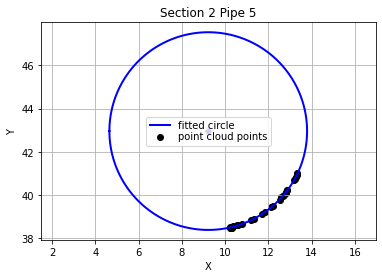

The fitted center point is: (9.220243,42.961779)
The as-designed center point is: (10.08213,39.285477)
The distance between them is: 3.7759827
The fitted radius is: 4.572727 and the actual radius is: 4.375
The difference between them is: 0.197727


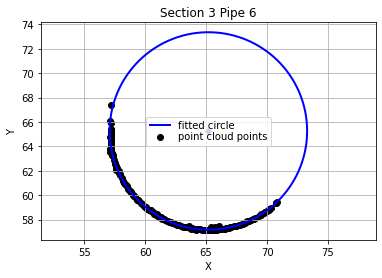

The fitted center point is: (65.189599,65.263093)
The as-designed center point is: (65.408948,63.691962)
The distance between them is: 1.586369
The fitted radius is: 8.093143 and the actual radius is: 8.0
The difference between them is: 0.093143


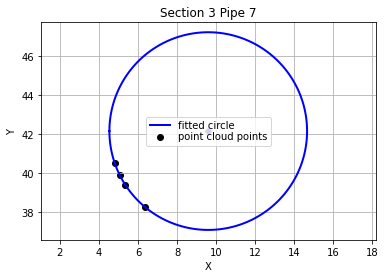

The fitted center point is: (9.59318,42.144872)
The as-designed center point is: (10.082139,38.654272)
The distance between them is: 3.52468
The fitted radius is: 5.059058 and the actual radius is: 4.375
The difference between them is: 0.684058


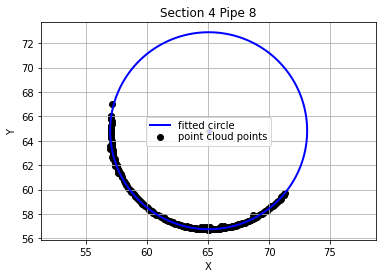

The fitted center point is: (65.049661,64.818584)
The as-designed center point is: (65.408948,63.686064)
The distance between them is: 1.1881451
The fitted radius is: 8.073103 and the actual radius is: 8.0
The difference between them is: 0.073103


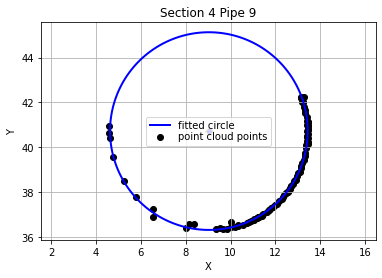

The fitted center point is: (9.031165,40.723612)
The as-designed center point is: (10.082159,38.36009)
The distance between them is: 2.5866628
The fitted radius is: 4.404457 and the actual radius is: 4.375
The difference between them is: 0.029457


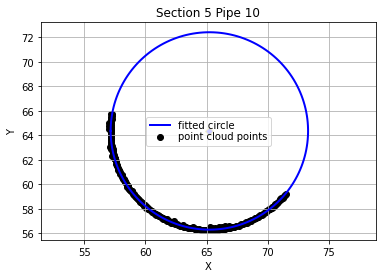

The fitted center point is: (65.228142,64.354606)
The as-designed center point is: (65.408947,63.692365)
The distance between them is: 0.6864791
The fitted radius is: 8.063315 and the actual radius is: 8.0
The difference between them is: 0.063315


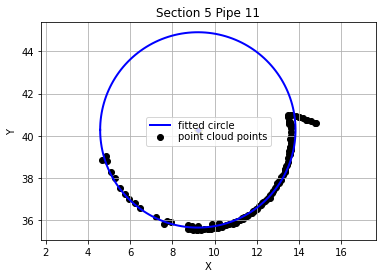

The fitted center point is: (9.205321,40.279732)
The as-designed center point is: (10.082174,38.413142)
The distance between them is: 2.0622874
The fitted radius is: 4.629424 and the actual radius is: 4.375
The difference between them is: 0.254424


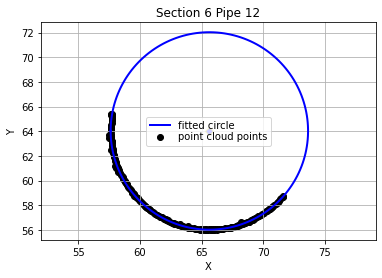

The fitted center point is: (65.632847,64.021699)
The as-designed center point is: (65.408948,63.689478)
The distance between them is: 0.4006265
The fitted radius is: 8.011102 and the actual radius is: 8.0
The difference between them is: 0.011102


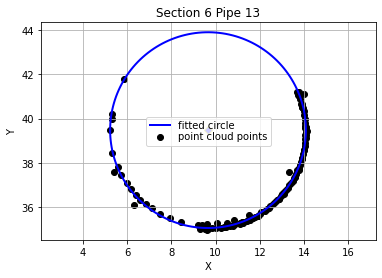

The fitted center point is: (9.65533,39.478078)
The as-designed center point is: (10.082196,38.720377)
The distance between them is: 0.8696697
The fitted radius is: 4.421676 and the actual radius is: 4.375
The difference between them is: 0.046676


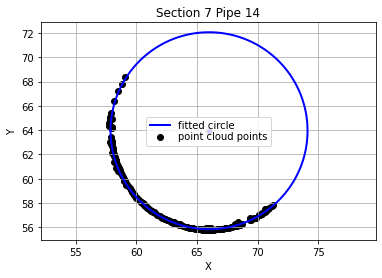

The fitted center point is: (65.987251,63.949842)
The as-designed center point is: (65.408948,63.689696)
The distance between them is: 0.6341217
The fitted radius is: 8.113989 and the actual radius is: 8.0
The difference between them is: 0.113989


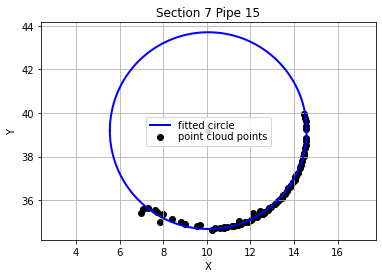

The fitted center point is: (10.063545,39.193671)
The as-designed center point is: (10.082214,39.186475)
The distance between them is: 0.0200078
The fitted radius is: 4.511609 and the actual radius is: 4.375
The difference between them is: 0.136609


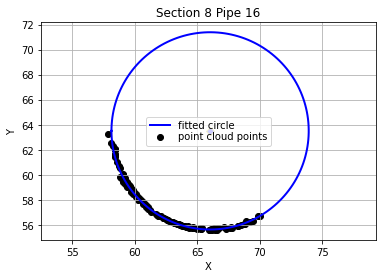

The fitted center point is: (66.027401,63.50477)
The as-designed center point is: (65.408947,63.688186)
The distance between them is: 0.6450789
The fitted radius is: 7.880821 and the actual radius is: 8.0
The difference between them is: 0.119179


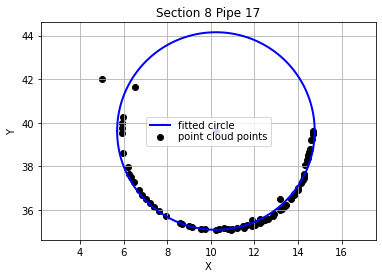

The fitted center point is: (10.232543,39.625675)
The as-designed center point is: (10.082227,39.797709)
The distance between them is: 0.2284526
The fitted radius is: 4.529311 and the actual radius is: 4.375
The difference between them is: 0.154311


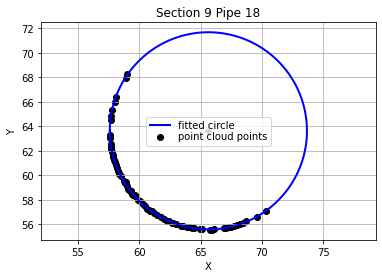

The fitted center point is: (65.639166,63.630014)
The as-designed center point is: (65.408949,63.69204)
The distance between them is: 0.2384263
The fitted radius is: 8.034913 and the actual radius is: 8.0
The difference between them is: 0.034913


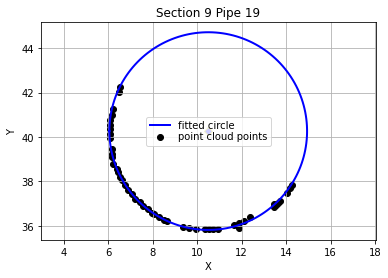

The fitted center point is: (10.491266,40.266187)
The as-designed center point is: (10.082258,40.52607)
The distance between them is: 0.4845892
The fitted radius is: 4.449228 and the actual radius is: 4.375
The difference between them is: 0.074228


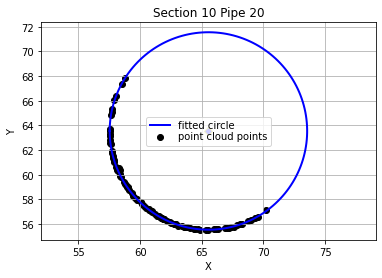

The fitted center point is: (65.537047,63.553469)
The as-designed center point is: (65.408947,63.689229)
The distance between them is: 0.1866558
The fitted radius is: 8.006475 and the actual radius is: 8.0
The difference between them is: 0.006475


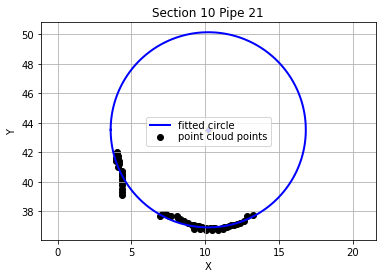

The fitted center point is: (10.197424,43.527464)
The as-designed center point is: (10.082269,41.290486)
The distance between them is: 2.23994
The fitted radius is: 6.605461 and the actual radius is: 4.375
The difference between them is: 2.230461


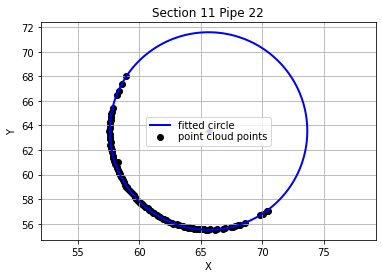

The fitted center point is: (65.624845,63.548947)
The as-designed center point is: (65.408948,63.68858)
The distance between them is: 0.2571165
The fitted radius is: 8.034264 and the actual radius is: 8.0
The difference between them is: 0.034264


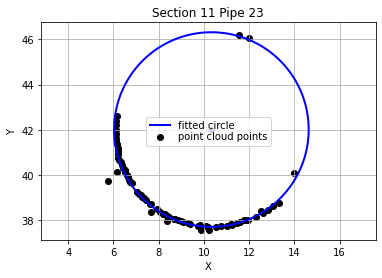

The fitted center point is: (10.332293,42.010187)
The as-designed center point is: (10.082281,42.084443)
The distance between them is: 0.2608064
The fitted radius is: 4.303519 and the actual radius is: 4.375
The difference between them is: 0.071481


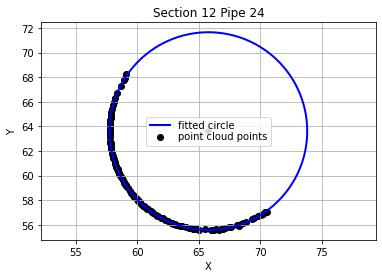

The fitted center point is: (65.793277,63.620596)
The as-designed center point is: (65.408948,63.689727)
The distance between them is: 0.390497
The fitted radius is: 8.028239 and the actual radius is: 8.0
The difference between them is: 0.028239


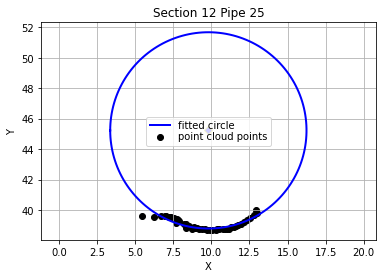

The fitted center point is: (9.798137,45.228896)
The as-designed center point is: (10.082301,42.906137)
The distance between them is: 2.3400766
The fitted radius is: 6.448591 and the actual radius is: 4.375
The difference between them is: 2.073591


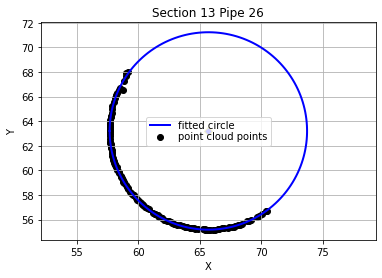

The fitted center point is: (65.702383,63.204625)
The as-designed center point is: (65.408952,63.690076)
The distance between them is: 0.5672428
The fitted radius is: 8.024176 and the actual radius is: 8.0
The difference between them is: 0.024176


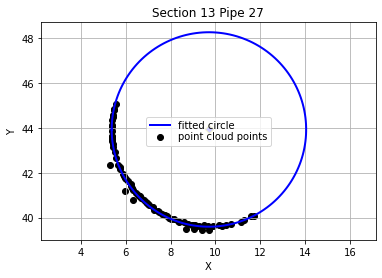

The fitted center point is: (9.711192,43.932498)
The as-designed center point is: (10.082316,43.687625)
The distance between them is: 0.44463
The fitted radius is: 4.33934 and the actual radius is: 4.375
The difference between them is: 0.03566


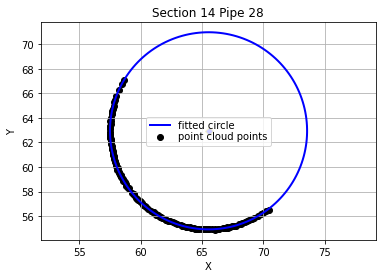

The fitted center point is: (65.540401,62.946509)
The as-designed center point is: (65.408924,63.689659)
The distance between them is: 0.7546907
The fitted radius is: 8.031407 and the actual radius is: 8.0
The difference between them is: 0.031407


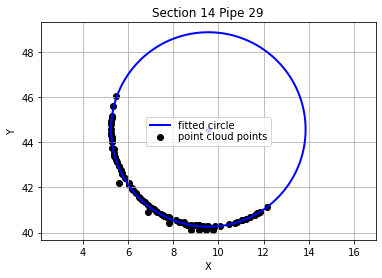

The fitted center point is: (9.551412,44.562985)
The as-designed center point is: (10.082326,44.444329)
The distance between them is: 0.5440119
The fitted radius is: 4.303656 and the actual radius is: 4.375
The difference between them is: 0.071344


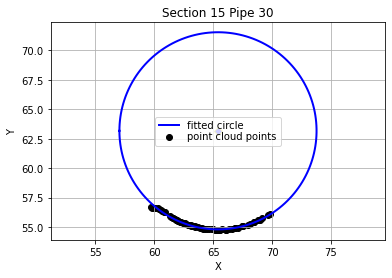

The fitted center point is: (65.407427,63.172442)
The as-designed center point is: (65.408993,63.690284)
The distance between them is: 0.5178444
The fitted radius is: 8.367594 and the actual radius is: 8.0
The difference between them is: 0.367594


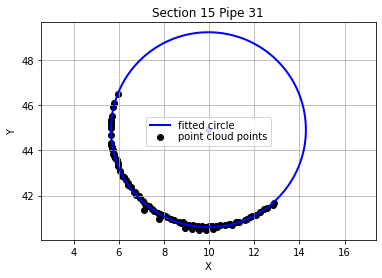

The fitted center point is: (9.964958,44.920748)
The as-designed center point is: (10.082381,45.177773)
The distance between them is: 0.2825774
The fitted radius is: 4.319071 and the actual radius is: 4.375
The difference between them is: 0.055929


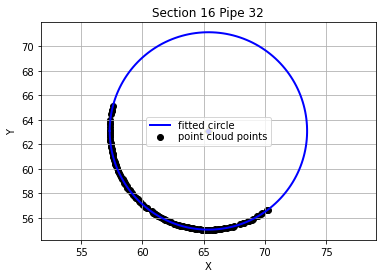

The fitted center point is: (65.387473,63.082535)
The as-designed center point is: (65.408901,63.688543)
The distance between them is: 0.6063867
The fitted radius is: 8.060035 and the actual radius is: 8.0
The difference between them is: 0.060035


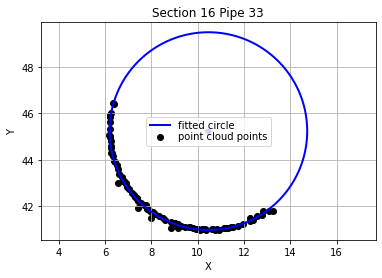

The fitted center point is: (10.462275,45.237099)
The as-designed center point is: (10.082121,45.884234)
The distance between them is: 0.7505337
The fitted radius is: 4.270643 and the actual radius is: 4.375
The difference between them is: 0.104357


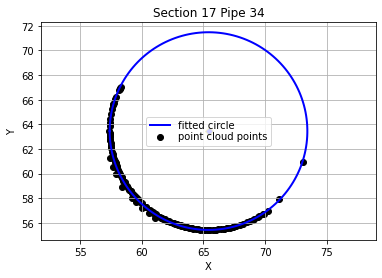

The fitted center point is: (65.412086,63.454874)
The as-designed center point is: (65.40897,63.691072)
The distance between them is: 0.2362186
The fitted radius is: 8.026417 and the actual radius is: 8.0
The difference between them is: 0.026417


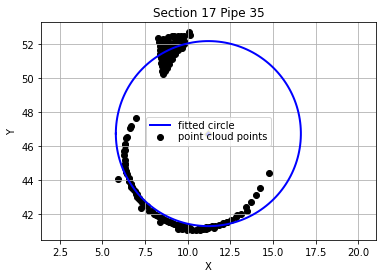

The fitted center point is: (11.21094,46.736962)
The as-designed center point is: (10.082129,46.573794)
The distance between them is: 1.1405429
The fitted radius is: 5.42444 and the actual radius is: 4.375
The difference between them is: 1.04944


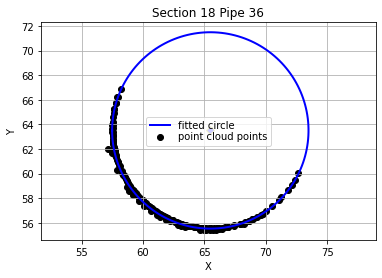

The fitted center point is: (65.474286,63.510138)
The as-designed center point is: (65.408959,63.690774)
The distance between them is: 0.1920859
The fitted radius is: 7.985188 and the actual radius is: 8.0
The difference between them is: 0.014812


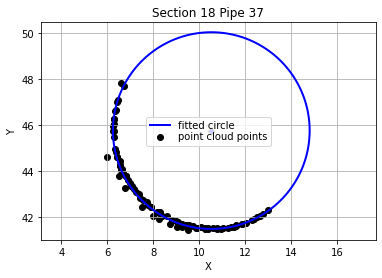

The fitted center point is: (10.522432,45.768273)
The as-designed center point is: (10.082411,47.244838)
The distance between them is: 1.5407345
The fitted radius is: 4.27565 and the actual radius is: 4.375
The difference between them is: 0.09935


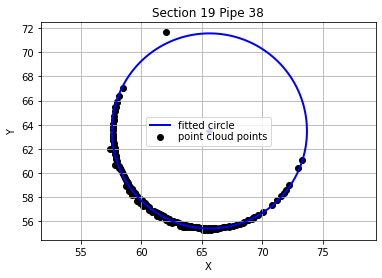

The fitted center point is: (65.640821,63.487259)
The as-designed center point is: (65.408918,63.678573)
The distance between them is: 0.3006327
The fitted radius is: 8.068657 and the actual radius is: 8.0
The difference between them is: 0.068657


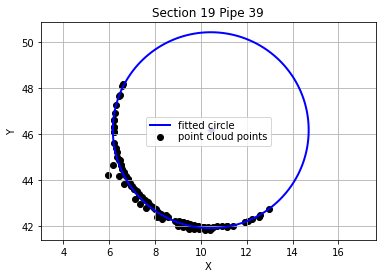

The fitted center point is: (10.430826,46.170829)
The as-designed center point is: (10.08238,47.924377)
The distance between them is: 1.7878325
The fitted radius is: 4.270426 and the actual radius is: 4.375
The difference between them is: 0.104574


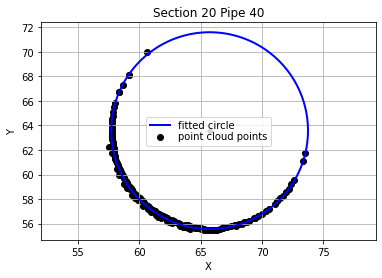

The fitted center point is: (65.733953,63.575664)
The as-designed center point is: (65.408993,63.725069)
The distance between them is: 0.3576603
The fitted radius is: 8.008307 and the actual radius is: 8.0
The difference between them is: 0.008307


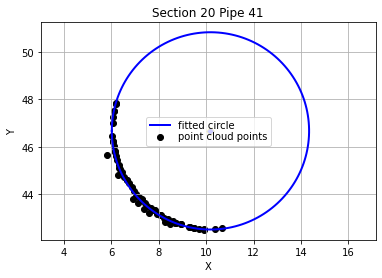

The fitted center point is: (10.179364,46.668805)
The as-designed center point is: (10.082403,48.612812)
The distance between them is: 1.9464236
The fitted radius is: 4.161884 and the actual radius is: 4.375
The difference between them is: 0.213116


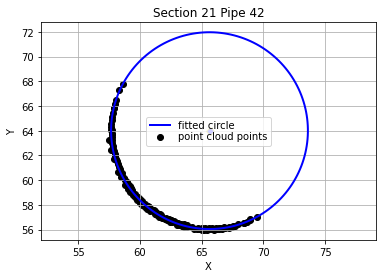

The fitted center point is: (65.630916,64.0064)
The as-designed center point is: (65.408892,63.636728)
The distance between them is: 0.4312216
The fitted radius is: 7.965578 and the actual radius is: 8.0
The difference between them is: 0.034422


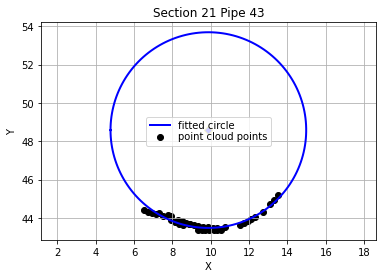

The fitted center point is: (9.873178,48.578641)
The as-designed center point is: (10.082445,49.31519)
The distance between them is: 0.7657004
The fitted radius is: 5.104622 and the actual radius is: 4.375
The difference between them is: 0.729622


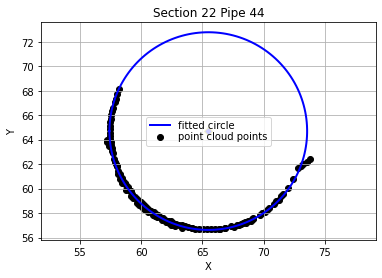

The fitted center point is: (65.485242,64.698802)
The as-designed center point is: (65.408988,63.715005)
The distance between them is: 0.9867478
The fitted radius is: 8.073413 and the actual radius is: 8.0
The difference between them is: 0.073413


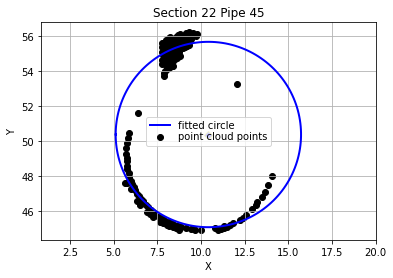

The fitted center point is: (10.424493,50.358589)
The as-designed center point is: (10.082591,50.16763)
The distance between them is: 0.391615
The fitted radius is: 5.30332 and the actual radius is: 4.375
The difference between them is: 0.92832


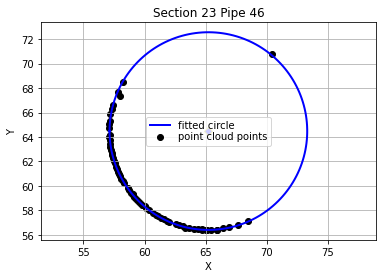

The fitted center point is: (65.223697,64.480788)
The as-designed center point is: (65.40894,63.68693)
The distance between them is: 0.8151843
The fitted radius is: 8.08981 and the actual radius is: 8.0
The difference between them is: 0.08981


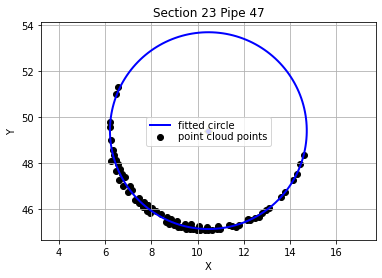

The fitted center point is: (10.465358,49.412325)
The as-designed center point is: (10.082391,50.094509)
The distance between them is: 0.782329
The fitted radius is: 4.264871 and the actual radius is: 4.375
The difference between them is: 0.110129


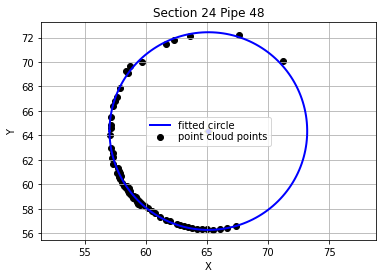

The fitted center point is: (65.124354,64.349142)
The as-designed center point is: (65.408944,63.688418)
The distance between them is: 0.7194079
The fitted radius is: 8.081975 and the actual radius is: 8.0
The difference between them is: 0.081975


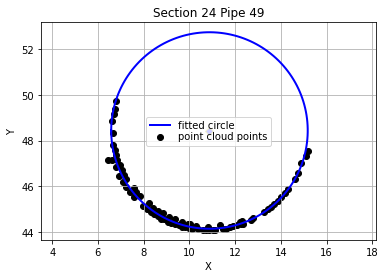

The fitted center point is: (10.878537,48.438351)
The as-designed center point is: (10.082476,48.592237)
The distance between them is: 0.8107984
The fitted radius is: 4.297934 and the actual radius is: 4.375
The difference between them is: 0.077066


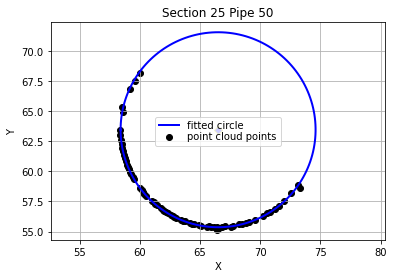

The fitted center point is: (66.50342,63.459554)
The as-designed center point is: (65.408948,63.6897)
The distance between them is: 1.1184079
The fitted radius is: 8.095988 and the actual radius is: 8.0
The difference between them is: 0.095988


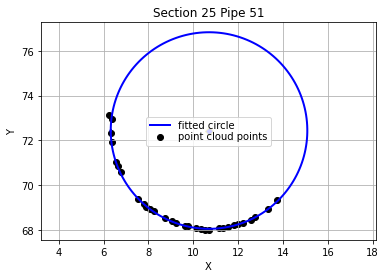

The fitted center point is: (10.702929,72.441775)
The as-designed center point is: (10.07984,72.187847)
The distance between them is: 0.6728442
The fitted radius is: 4.383088 and the actual radius is: 4.375
The difference between them is: 0.008088


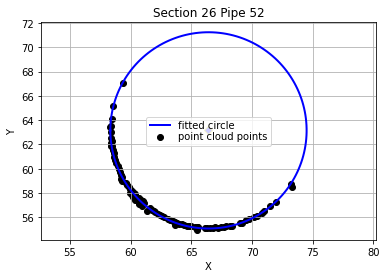

The fitted center point is: (66.411961,63.157426)
The as-designed center point is: (65.408948,63.689577)
The distance between them is: 1.1354381
The fitted radius is: 8.081907 and the actual radius is: 8.0
The difference between them is: 0.081907


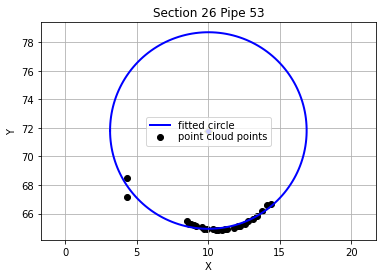

The fitted center point is: (10.007577,71.815674)
The as-designed center point is: (10.080441,69.043439)
The distance between them is: 2.7731924
The fitted radius is: 6.878084 and the actual radius is: 4.375
The difference between them is: 2.503084


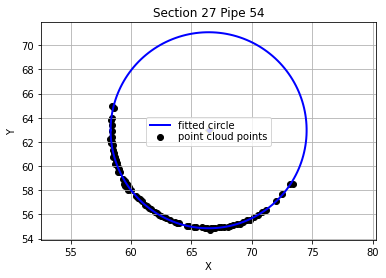

The fitted center point is: (66.422551,62.967601)
The as-designed center point is: (65.408949,63.689785)
The distance between them is: 1.2445637
The fitted radius is: 8.110732 and the actual radius is: 8.0
The difference between them is: 0.110732


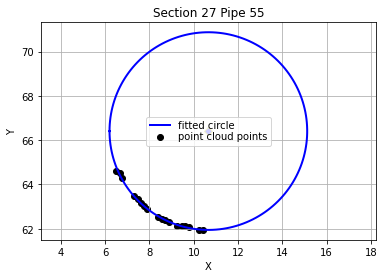

The fitted center point is: (10.660392,66.411772)
The as-designed center point is: (10.081235,66.270062)
The distance between them is: 0.596242
The fitted radius is: 4.463651 and the actual radius is: 4.375
The difference between them is: 0.088651


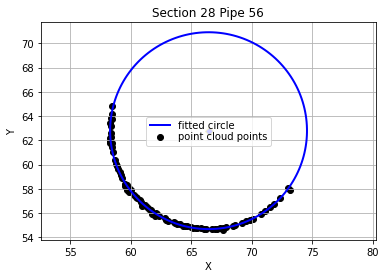

The fitted center point is: (66.430623,62.794519)
The as-designed center point is: (65.408948,63.689812)
The distance between them is: 1.3584437
The fitted radius is: 8.127338 and the actual radius is: 8.0
The difference between them is: 0.127338


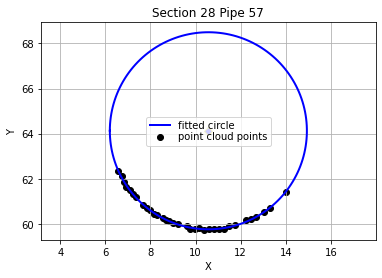

The fitted center point is: (10.568788,64.127282)
The as-designed center point is: (10.081893,63.977636)
The distance between them is: 0.5093728
The fitted radius is: 4.37001 and the actual radius is: 4.375
The difference between them is: 0.00499


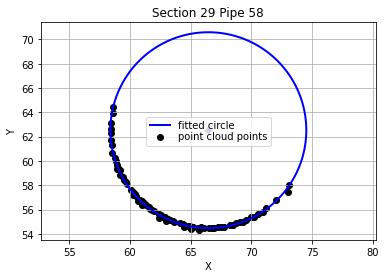

The fitted center point is: (66.453174,62.531431)
The as-designed center point is: (65.408948,63.690343)
The distance between them is: 1.5599631
The fitted radius is: 8.053042 and the actual radius is: 8.0
The difference between them is: 0.053042


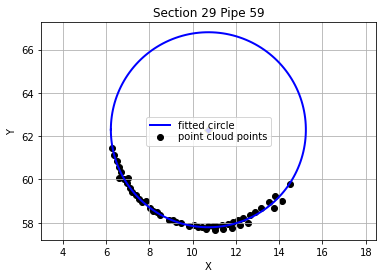

The fitted center point is: (10.72854,62.296343)
The as-designed center point is: (10.082405,62.12921)
The distance between them is: 0.6674008
The fitted radius is: 4.503128 and the actual radius is: 4.375
The difference between them is: 0.128128


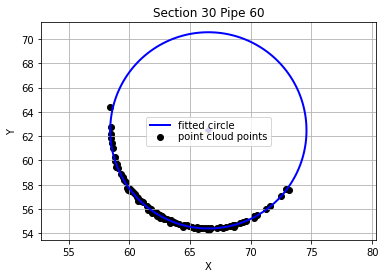

The fitted center point is: (66.50816,62.478946)
The as-designed center point is: (65.408949,63.688414)
The distance between them is: 1.6343432
The fitted radius is: 8.082315 and the actual radius is: 8.0
The difference between them is: 0.082315


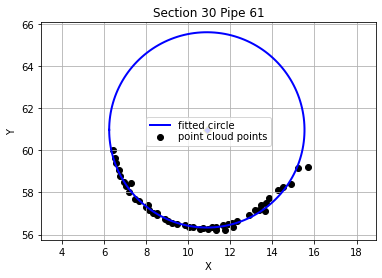

The fitted center point is: (10.885719,60.972891)
The as-designed center point is: (10.08278,60.705438)
The distance between them is: 0.8463109
The fitted radius is: 4.640732 and the actual radius is: 4.375
The difference between them is: 0.265732


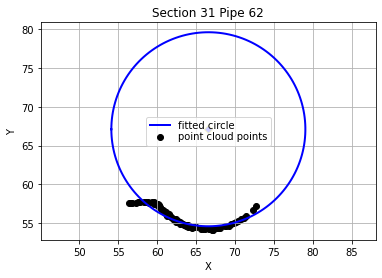

The fitted center point is: (66.575369,67.096383)
The as-designed center point is: (65.408948,63.690452)
The distance between them is: 3.6001255
The fitted radius is: 12.477005 and the actual radius is: 8.0
The difference between them is: 4.477005


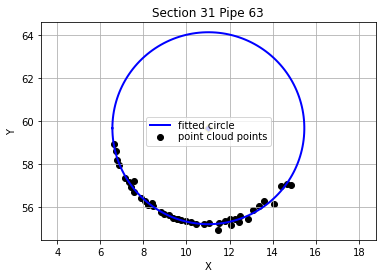

The fitted center point is: (11.017872,59.672363)
The as-designed center point is: (10.083039,59.69753)
The distance between them is: 0.9351717
The fitted radius is: 4.455749 and the actual radius is: 4.375
The difference between them is: 0.080749


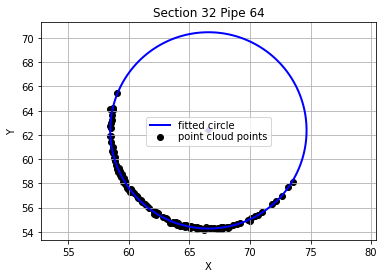

The fitted center point is: (66.570166,62.375601)
The as-designed center point is: (65.408948,63.692353)
The distance between them is: 1.7556375
The fitted radius is: 8.103922 and the actual radius is: 8.0
The difference between them is: 0.103922


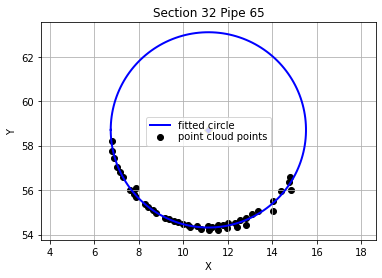

The fitted center point is: (11.12468,58.70924)
The as-designed center point is: (10.083196,58.967741)
The distance between them is: 1.0730851
The fitted radius is: 4.391154 and the actual radius is: 4.375
The difference between them is: 0.016154


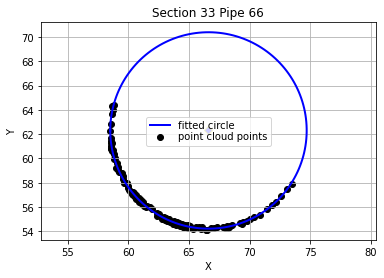

The fitted center point is: (66.606012,62.300449)
The as-designed center point is: (65.408949,63.687198)
The distance between them is: 1.8319478
The fitted radius is: 8.087724 and the actual radius is: 8.0
The difference between them is: 0.087724


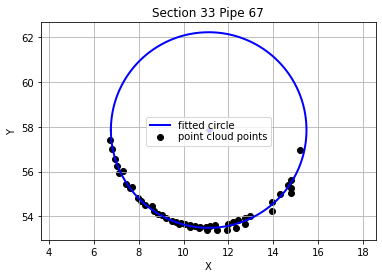

The fitted center point is: (11.120357,57.854717)
The as-designed center point is: (10.083322,58.362505)
The distance between them is: 1.1546819
The fitted radius is: 4.361402 and the actual radius is: 4.375
The difference between them is: 0.013598


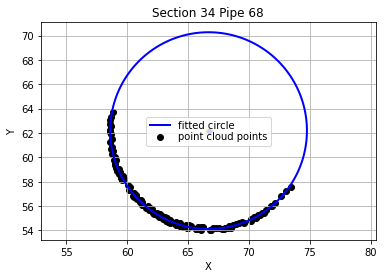

The fitted center point is: (66.692622,62.195823)
The as-designed center point is: (65.408948,63.69103)
The distance between them is: 1.9706504
The fitted radius is: 8.079128 and the actual radius is: 8.0
The difference between them is: 0.079128


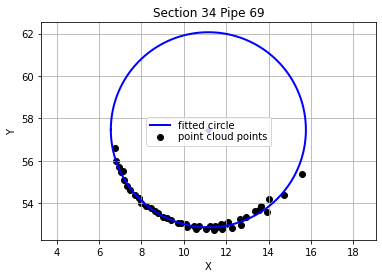

The fitted center point is: (11.155088,57.463281)
The as-designed center point is: (10.083418,57.894635)
The distance between them is: 1.1552242
The fitted radius is: 4.599877 and the actual radius is: 4.375
The difference between them is: 0.224877


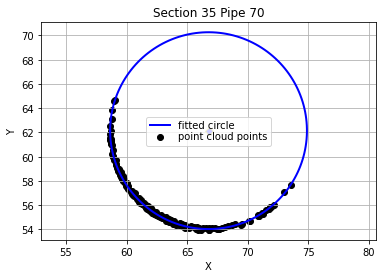

The fitted center point is: (66.76537,62.14737)
The as-designed center point is: (65.408949,63.689333)
The distance between them is: 2.0536621
The fitted radius is: 8.116236 and the actual radius is: 8.0
The difference between them is: 0.116236


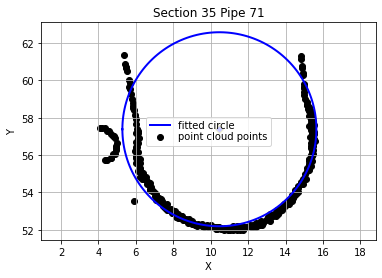

The fitted center point is: (10.463267,57.380902)
The as-designed center point is: (10.083487,57.562777)
The distance between them is: 0.4210836
The fitted radius is: 5.184956 and the actual radius is: 4.375
The difference between them is: 0.809956


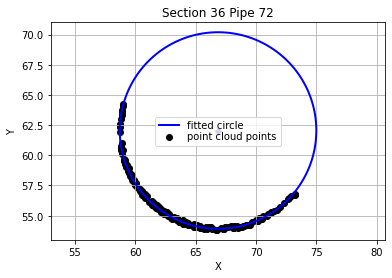

The fitted center point is: (66.850131,62.053346)
The as-designed center point is: (65.408948,63.689723)
The distance between them is: 2.1805362
The fitted radius is: 8.140768 and the actual radius is: 8.0
The difference between them is: 0.140768


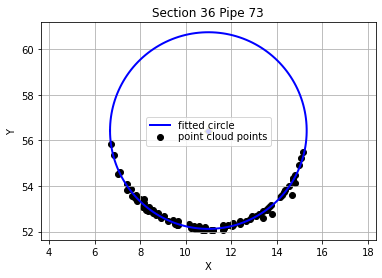

The fitted center point is: (10.996269,56.429968)
The as-designed center point is: (10.083533,57.360924)
The distance between them is: 1.3037508
The fitted radius is: 4.314669 and the actual radius is: 4.375
The difference between them is: 0.060331


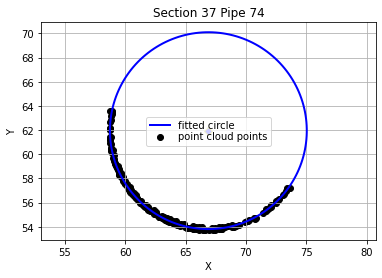

The fitted center point is: (66.887355,61.956095)
The as-designed center point is: (65.408948,63.689727)
The distance between them is: 2.2784133
The fitted radius is: 8.147331 and the actual radius is: 8.0
The difference between them is: 0.147331


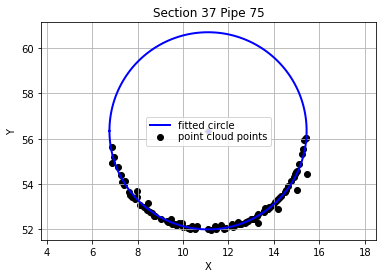

The fitted center point is: (11.098327,56.345466)
The as-designed center point is: (10.083555,57.297695)
The distance between them is: 1.3915827
The fitted radius is: 4.342916 and the actual radius is: 4.375
The difference between them is: 0.032084


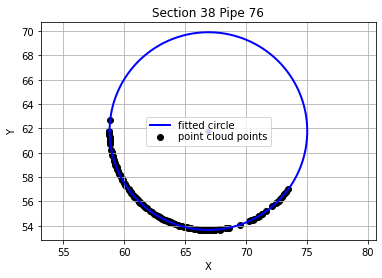

The fitted center point is: (66.905674,61.777019)
The as-designed center point is: (65.408948,63.690329)
The distance between them is: 2.4291858
The fitted radius is: 8.118172 and the actual radius is: 8.0
The difference between them is: 0.118172


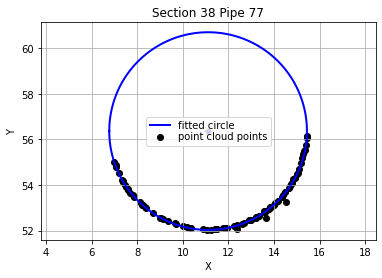

The fitted center point is: (11.109577,56.362586)
The as-designed center point is: (10.083534,57.382158)
The distance between them is: 1.4464755
The fitted radius is: 4.336993 and the actual radius is: 4.375
The difference between them is: 0.038007


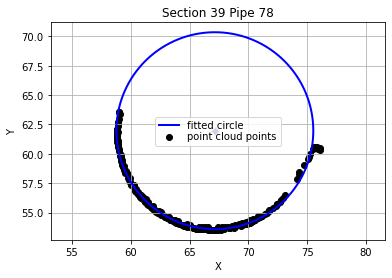

The fitted center point is: (67.151353,61.971521)
The as-designed center point is: (65.408949,63.689107)
The distance between them is: 2.4466453
The fitted radius is: 8.374823 and the actual radius is: 8.0
The difference between them is: 0.374823


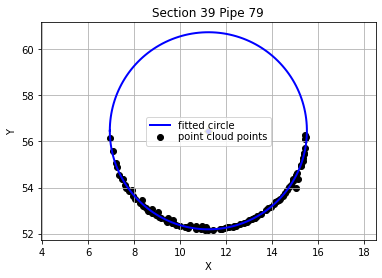

The fitted center point is: (11.227286,56.464408)
The as-designed center point is: (10.083534,57.421295)
The distance between them is: 1.4912416
The fitted radius is: 4.278663 and the actual radius is: 4.375
The difference between them is: 0.096337


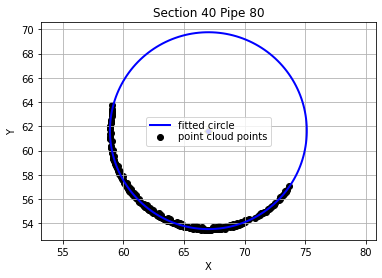

The fitted center point is: (67.003823,61.641215)
The as-designed center point is: (65.408948,63.689841)
The distance between them is: 2.5962463
The fitted radius is: 8.123897 and the actual radius is: 8.0
The difference between them is: 0.123897


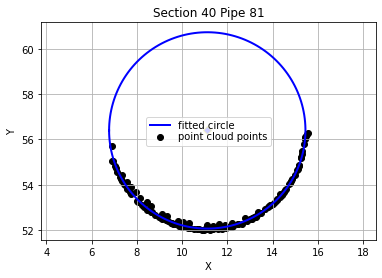

The fitted center point is: (11.114399,56.399006)
The as-designed center point is: (10.083565,57.317245)
The distance between them is: 1.3805005
The fitted radius is: 4.340527 and the actual radius is: 4.375
The difference between them is: 0.034473


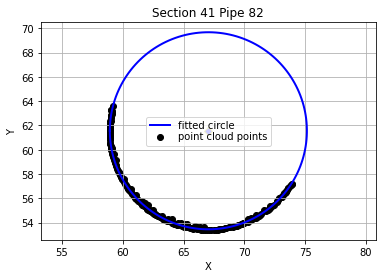

The fitted center point is: (67.040568,61.559647)
The as-designed center point is: (65.408949,63.689687)
The distance between them is: 2.683142
The fitted radius is: 8.109372 and the actual radius is: 8.0
The difference between them is: 0.109372


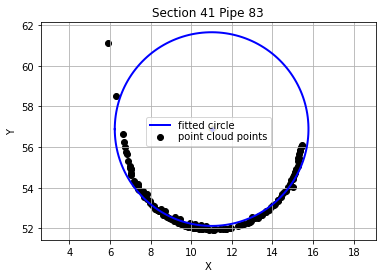

The fitted center point is: (11.002146,56.886378)
The as-designed center point is: (10.0836,57.146347)
The distance between them is: 0.9546259
The fitted radius is: 4.770391 and the actual radius is: 4.375
The difference between them is: 0.395391


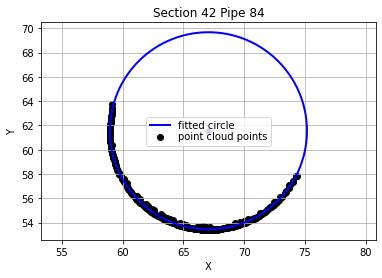

The fitted center point is: (67.062067,61.564163)
The as-designed center point is: (65.408948,63.689807)
The distance between them is: 2.6927987
The fitted radius is: 8.113448 and the actual radius is: 8.0
The difference between them is: 0.113448


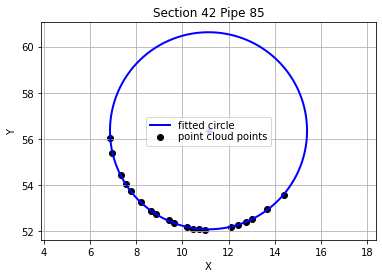

The fitted center point is: (11.1313,56.354853)
The as-designed center point is: (10.08362,57.019061)
The distance between them is: 1.2404861
The fitted radius is: 4.267773 and the actual radius is: 4.375
The difference between them is: 0.107227


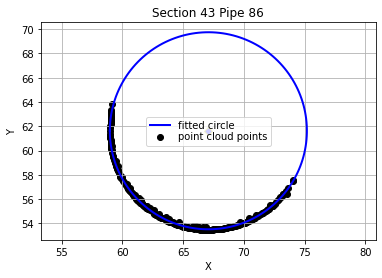

The fitted center point is: (67.075813,61.633381)
The as-designed center point is: (65.408948,63.689855)
The distance between them is: 2.6471729
The fitted radius is: 8.111924 and the actual radius is: 8.0
The difference between them is: 0.111924


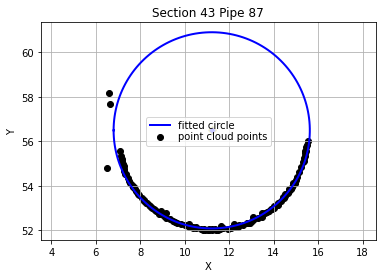

The fitted center point is: (11.21325,56.49782)
The as-designed center point is: (10.083636,56.951211)
The distance between them is: 1.2172063
The fitted radius is: 4.412042 and the actual radius is: 4.375
The difference between them is: 0.037042


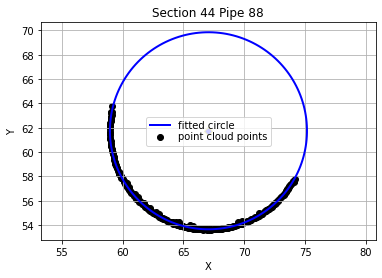

The fitted center point is: (67.053759,61.750549)
The as-designed center point is: (65.408948,63.688445)
The distance between them is: 2.5418191
The fitted radius is: 8.09954 and the actual radius is: 8.0
The difference between them is: 0.09954


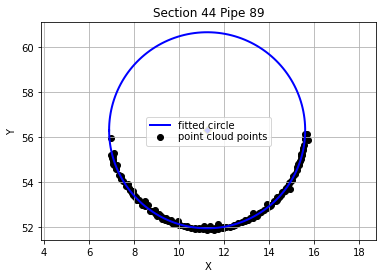

The fitted center point is: (11.247482,56.296164)
The as-designed center point is: (10.083653,56.917248)
The distance between them is: 1.3191828
The fitted radius is: 4.354786 and the actual radius is: 4.375
The difference between them is: 0.020214


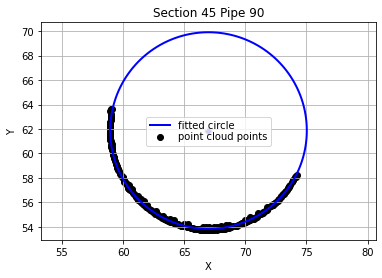

The fitted center point is: (66.985944,61.870546)
The as-designed center point is: (65.408947,63.692689)
The distance between them is: 2.4097976
The fitted radius is: 8.044214 and the actual radius is: 8.0
The difference between them is: 0.044214


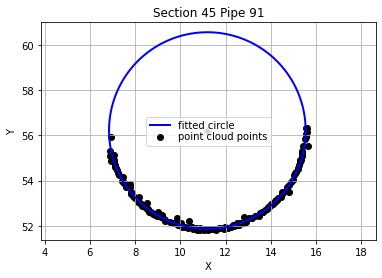

The fitted center point is: (11.194302,56.212786)
The as-designed center point is: (10.083663,56.92133)
The distance between them is: 1.3174041
The fitted radius is: 4.345769 and the actual radius is: 4.375
The difference between them is: 0.029231


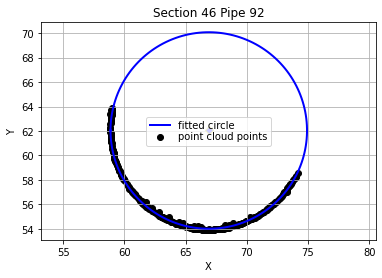

The fitted center point is: (66.893426,62.041723)
The as-designed center point is: (65.40895,63.6881)
The distance between them is: 2.2168054
The fitted radius is: 8.026562 and the actual radius is: 8.0
The difference between them is: 0.026562


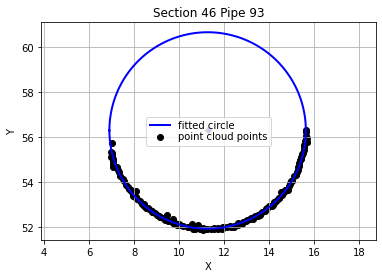

The fitted center point is: (11.264086,56.28503)
The as-designed center point is: (10.083667,56.974843)
The distance between them is: 1.3671982
The fitted radius is: 4.36073 and the actual radius is: 4.375
The difference between them is: 0.01427


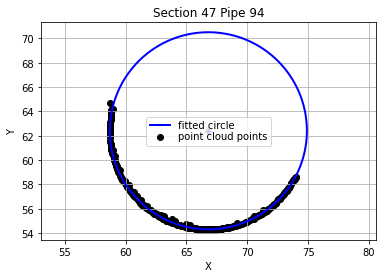

The fitted center point is: (66.798947,62.410048)
The as-designed center point is: (65.408945,63.690036)
The distance between them is: 1.88957
The fitted radius is: 8.098953 and the actual radius is: 8.0
The difference between them is: 0.098953


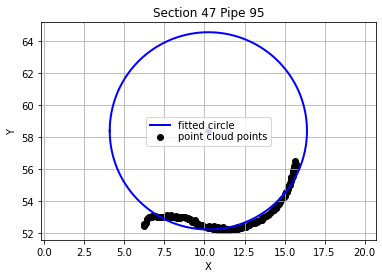

The fitted center point is: (10.241175,58.38115)
The as-designed center point is: (10.083647,57.131381)
The distance between them is: 1.2596577
The fitted radius is: 6.163101 and the actual radius is: 4.375
The difference between them is: 1.788101


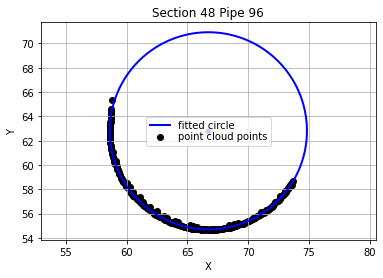

The fitted center point is: (66.71912,62.812118)
The as-designed center point is: (65.408953,63.68961)
The distance between them is: 1.5768734
The fitted radius is: 8.109121 and the actual radius is: 8.0
The difference between them is: 0.109121


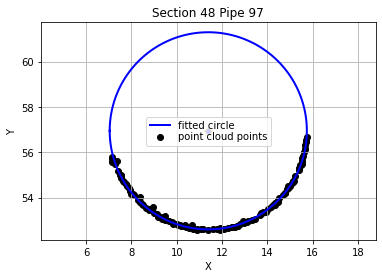

The fitted center point is: (11.391748,56.943649)
The as-designed center point is: (10.083599,57.402983)
The distance between them is: 1.3864493
The fitted radius is: 4.350779 and the actual radius is: 4.375
The difference between them is: 0.024221


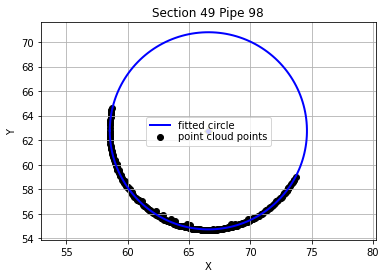

The fitted center point is: (66.579681,62.760035)
The as-designed center point is: (65.408947,63.689732)
The distance between them is: 1.4949765
The fitted radius is: 8.037947 and the actual radius is: 8.0
The difference between them is: 0.037947


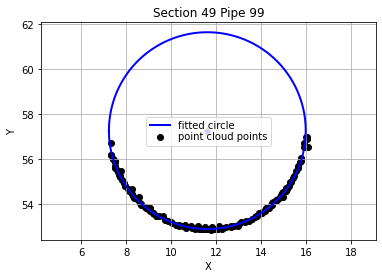

The fitted center point is: (11.598032,57.249152)
The as-designed center point is: (10.083495,57.793803)
The distance between them is: 1.6094928
The fitted radius is: 4.370018 and the actual radius is: 4.375
The difference between them is: 0.004982


"\nx_real_life = [x for x in cloud_sections['X']]\ny_real_life = [y for y in cloud_sections['Y']]\n\ncoords = [[x_real_life[i], y_real_life[i]] for i in range(len((x_real_life)))]\n\nxc,yc,r,s = hyper_fit(coords)\nplot_data_circle(x_real_life,y_real_life,xc,yc,r)\n    \n   "

In [11]:
from circle_fit import hyper_fit, plot_data_circle

sec_count = 0
for n in range(50): 
    a = PassesSecondNoiseTestBySection[2 * n:2 * n + 2]
    if len(a[0]) > 0:
        #print(a[0])
        xc,yc,r,s = hyper_fit(a[0])
        plot_data_circle((list(zip(*a[0]))[0]),(list(zip(*a[0]))[1]),xc,yc,r)
        plt.title("Section " + str(sec_count) + " Pipe " + str(sec_count*2))
        plt.show()
        printInfo(r, xc, yc, sec_count, 0)
    else:
        pass
    if len(a[1]) > 0:
        #print(a[1])
        xc,yc,r,s = hyper_fit(a[1])
        plot_data_circle((list(zip(*a[1]))[0]),(list(zip(*a[1]))[1]),xc,yc,r)
        plt.title("Section " + str(sec_count) + " Pipe " + str(sec_count*2 + 1))
        plt.show()
        printInfo(r, xc, yc, sec_count, 1)
    else:
        pass
    sec_count += 1
"""
x_real_life = [x for x in cloud_sections['X']]
y_real_life = [y for y in cloud_sections['Y']]

coords = [[x_real_life[i], y_real_life[i]] for i in range(len((x_real_life)))]

xc,yc,r,s = hyper_fit(coords)
plot_data_circle(x_real_life,y_real_life,xc,yc,r)
    
   """